In [68]:
import netket as nk
import netket.experimental as nkx
from netket.operator.spin import sigmax,sigmaz, identity, sigmam, sigmap
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
import jax
from netket.graph import Graph, Chain
from netket.operator._local_operator import LocalOperator
from netket.operator import AbstractSuperOperator
import numpy as np

In [69]:
N = 4

In [70]:
# Copyright 2021 The NetKet Authors - All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Any
import warnings

import igraph as ig
from flax import linen as nn
import jax
from jax import numpy as jnp
import numpy as np
from jax.nn.initializers import normal

from netket.utils import deprecate_dtype
from netket.graph import AbstractGraph, Chain
from netket.hilbert import AbstractHilbert
from netket.utils.types import NNInitFunc


@deprecate_dtype
class MPSMod(nn.Module):
    r"""
    A periodic Matrix Product State (MPS) for a quantum state of discrete
    degrees of freedom, wrapped as Jax machine.

    The MPS is defined as

    .. math:: \Psi(s_1,\dots s_N) = \mathrm{Tr} \left[ A[s_1]\dots A[s_N] \right] ,

    for arbitrary local quantum numbers :math:`s_i`, where :math:`A[s_1]` is a matrix
    of dimension (bdim,bdim), depending on the value of the local quantum number :math:`s_i`.
    """

    hilbert: AbstractHilbert
    """Hilbert space on which the state is defined."""
    graph: AbstractGraph
    """The graph on which the system is defined."""
    bond_dim: int
    """Virtual dimension of the MPS tensors."""
    diag: bool = False
    """Whether or not to use diagonal matrices in the MPS tensors."""
    symperiod: bool = None
    """
    Periodicity in the chain of MPS tensors.

    The chain of MPS tensors is constructed as a sequence of identical
    unit cells consisting of symperiod tensors. if None, symperiod equals the
    number of physical degrees of freedom.
    """
    kernel_init: NNInitFunc = normal(
        stddev=0.01
    )  # default standard deviation equals 1e-2
    """the initializer for the MPS weights."""
    param_dtype: Any = np.complex64
    """complex or float, whether the variational parameters of the MPS are real or complex."""

    def setup(self):
        L = self.hilbert.size
        phys_dim = self.hilbert.local_size

        self._L = L
        self._phys_dim = phys_dim

        # determine transformation from local states to indices
        local_states = np.array(self.hilbert.local_states)
        loc_vals_spacing = np.roll(local_states, -1)[0:-1] - local_states[0:-1]
        if np.max(loc_vals_spacing) == np.min(loc_vals_spacing):
            self._loc_vals_spacing = jnp.array(loc_vals_spacing[0])
        else:
            raise AssertionError(
                "JaxMpsPeriodic can only be used with evenly spaced hilbert local values"
            )
        self._loc_vals_bias = jnp.min(local_states)

        # check whether graph is periodic chain
        chain_graph = Chain(self.graph.n_edges).to_igraph()
        if not ig.Graph(edges=self.graph.edges()).isomorphic(chain_graph):
            warnings.warn(
                "Warning: graph is not isomorphic to chain with periodic boundary conditions",
                UserWarning,
            )

        # determine shape of unit cell
        if self.symperiod is None:
            self._symperiod = L
        else:
            self._symperiod = self.symperiod

        if L % self._symperiod == 0 and self._symperiod > 0:
            if self.diag:
                unit_cell_shape = (self._symperiod, phys_dim, self.bond_dim)
            else:
                unit_cell_shape = (
                    self._symperiod,
                    phys_dim,
                    self.bond_dim,
                    self.bond_dim,
                )
        else:
            raise AssertionError(
                "The number of degrees of freedom of the Hilbert space needs to be a multiple of the period of the MPS"
            )

        # define diagonal tensors with correct unit cell shape
        if self.diag:
            iden_tensors = jnp.ones(
                (self._symperiod, phys_dim, self.bond_dim), dtype=self.param_dtype
            )
        else:
            iden_tensors = jnp.repeat(
                jnp.eye(self.bond_dim, dtype=self.param_dtype)[jnp.newaxis, :, :],
                self._symperiod * phys_dim,
                axis=0,
            )
            iden_tensors = iden_tensors.reshape(
                self._symperiod, phys_dim, self.bond_dim, self.bond_dim
            )

        self.kernel = (
            self.param("kernel", self.kernel_init, unit_cell_shape, self.param_dtype)
            + iden_tensors
        )

        ## Gaussian sector part 
        self.phys_A = jnp.array([[[0,0],[1,0]],[[0,1],[0,0]],[[1,0],[0,0]]])

    @nn.compact
    def __call__(self, x):
        
        # expand diagonal to square matrices if diagonal mps
        if self.diag:
            params = jnp.einsum(
                "ijk,kl->ijkl", self.kernel, jnp.eye(self.kernel.shape[-1])
            )
        else:
            params = self.kernel
        
        # create all tensors in mps from unit cell
        all_tensors = jnp.tile(params, (self._L // self._symperiod, 1, 1, 1))
        all_phystensors = jnp.tile(self.phys_A, (self._L, 1, 1, 1))
        # transform input to indices
        x = (x - self._loc_vals_bias) / self._loc_vals_spacing
        if len(x.shape) == 1:  # batch size is one
            x = jnp.expand_dims(x, 0)

        def select_tensor(tensor, index):
            return tensor[index.astype(int)]

        def select_all_tensors(all_tensors, indices):
            return jax.vmap(select_tensor)(all_tensors, indices)

        # select right tensors using input for matrix multiplication
        selected_tensors = jax.vmap(select_all_tensors, (None, 0))(all_tensors, x)
        sel_phys_tensors = jax.vmap(select_all_tensors, (None, 0))(all_phystensors, x)

        # create loop carry, in this case a unit matrix
        edges = jnp.repeat(
            jnp.eye(self.bond_dim, dtype=selected_tensors.dtype)[jnp.newaxis, :, :],
            selected_tensors.shape[0],
            axis=0,
        )
        edges_phys = jnp.repeat(
            jnp.eye(2, dtype=sel_phys_tensors.dtype)[jnp.newaxis, :, :],
            sel_phys_tensors.shape[0],
            axis=0,
        )

        def trace_mps(tensors, edge):
            def multiply_tensors(left_tensor, right_tensor):
                return jnp.einsum("ij,jk->ik", left_tensor, right_tensor), None

            edge, _ = jax.lax.scan(multiply_tensors, edge, tensors)
            
            return jnp.trace(edge)
        
        def sum_coeff(tensors, edge,):
            def multiply_tensors(left_tensor, right_tensor):
                return jnp.einsum("ij,jk->ik", left_tensor, right_tensor), None

            edge, _ = jax.lax.scan(multiply_tensors, edge, tensors)
            return jnp.trace(jnp.einsum("ij,jk->ik", edge, edge.transpose()))
        
        # trace the matrix multiplication
        return jnp.log(1+jax.vmap(trace_mps)(selected_tensors, edges)*jax.vmap(sum_coeff)(sel_phys_tensors, edges_phys))

In [71]:
site_hilbert = nkx.hilbert.SpinOrbitalFermions(N,s=None)
link_hilbert = nkx.hilbert.SpinOrbitalFermions(N, s=None)

In [72]:
tot_hi = site_hilbert*link_hilbert
# tot_hi = nkx.hilbert.SpinOrbitalFermions(N,s=0.5)

In [73]:
class prod_op(AbstractSuperOperator):
    __module__ = "netket.operator"
    def __init__(self, hilbert, f_op, s_op, dtype = None):
        super.__init__(hilbert)
        self.a = 0
        self._dtype = dtype
        
    @property
    def dtype(self):
        return self._dtype

    @property
    def is_hermitian(self):
        return False
    
    


In [74]:
ch = Chain(N)

### We first print various properties of our Hilbert Space and define the QLM spin 1 equivalent Hamiltonian
$$H = -\frac{t}{2}\sum_i(S_i^+ S_{i+1}^-P_i^{(0)}P_{i+1}^{(0)}+ S_i^- S_{i+1}^+ P_i^{(1)} P_{i+1}^{(-1)}) -m\sum_i(S_i^z)^2$$

In [96]:
vars(tot_hi)

{'_hilbert_spaces': (SpinOrbitalFermions(n_orbitals=4),
  SpinOrbitalFermions(n_orbitals=4)),
 '_n_hilbert_spaces': 2,
 '_hilbert_i': array([0, 0, 0, 0, 1, 1, 1, 1]),
 '_sizes': (4, 4),
 '_cum_sizes': array([4, 8]),
 '_cum_indices': array([0, 4, 8]),
 '_size': 8,
 '_delta_indices_i': array([0, 0, 0, 0, 4, 4, 4, 4]),
 '_shape': (2, 2, 2, 2, 2, 2, 2, 2),
 '_hash': -4001755271268968178,
 '_ns_states': [16, 16],
 '_ns_states_r': array([16, 16]),
 '_cum_ns_states': array([  0,  16, 256]),
 '_cum_ns_states_r': array([16,  1]),
 '_n_states': 256}

In [76]:
identity(tot_hi)

LocalOperator(dim=8, acting_on=[], constant=1.0, dtype=float64)

In [77]:
tot_hi.all_states()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [91]:
def exp_op(op, max_range = 5):
    return np.sum([np.prod([op for i in range(n)])*(1/np.math.factorial(n)) for n in range(max_range)])

To satisfy for netket's problem of not being able to multiply fermionic operators and spin operators, we use the Jordan-Wigner transformation to describe spins with fermions

In [92]:
mu = 1
eps = 1
H = 0
S0 = 2
fs_c = [cdag(link_hilbert,i) for i in range(N)]
fs_d = [c(link_hilbert,i) for i in range(N)]
fs_n = [nc(link_hilbert,i) for i in range(N)]
exponents = [1j*np.pi*np.sum([fs_n[k] for k in range(0,i)]) for i in range(N)]
gauge_ops = [exp_op(-exponents[i])*fs_c[i] for i in range(N)]
sig_z_ops = [2*fs_n[i] -1 for i in range(N)]
f_create_ops = [cdag(site_hilbert,i) for i in range(N)]
f_destroy_ops = [c(site_hilbert,i) for i in range(N)]
f_num_ops = [nc(site_hilbert,i) for i in range(N)]
for i in range(N):
    H += mu*(-1)**i*f_num_ops[i]
    H -= eps*f_create_ops[i]*gauge_ops[i]*f_destroy_ops[(i+1)%N]
    H += sig_z_ops[i] - (-1)**i*S0
H += H.transpose().conjugate()

In [93]:
H.is_hermitian

True

In [90]:
H

FermionOperator2nd(hilbert=SpinOrbitalFermions(n_orbitals=4), n_operators=434, dtype=complex128)

In [94]:
vstate  = nk.vqs.MCState(nk.sampler.MetropolisLocal(tot_hi), MPSMod(tot_hi,ch, bond_dim=10))

AttributeError: 'TensorDiscreteHilbert' object has no attribute 'local_size'

In [ ]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(H.to_sparse(), k=2, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

E_gs = eig_vals[0]

eigenvalues with scipy sparse: [-32.12499623 -32.1240384 ]


In [ ]:
from tqdm import tqdm

energy_history = []
n_steps = 200

# For every iteration (tqdm is just a progress bar)
for i in tqdm(range(n_steps)):
    # compute energy and gradient of the energy
    E, E_grad = vstate.expect_and_grad(H)
    # log the energy to a list
    energy_history.append(E.mean.real)
    # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
    # function on every leaf of the dictionaries containing the set of parameters
    new_pars = jax.tree_map(lambda x,y: x-0.05*y, vstate.parameters, E_grad)
    # actually update the paramters
    vstate.parameters = new_pars

100%|██████████| 200/200 [00:43<00:00,  4.64it/s]


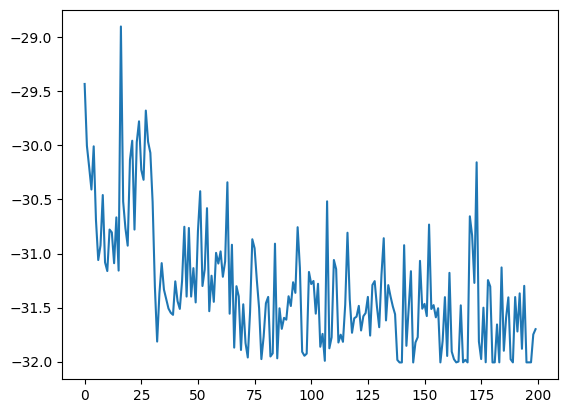

In [ ]:
import matplotlib.pyplot as plt
plt.plot(energy_history)

### We will compute the behavior of the electric flux $\varepsilon = \sum_x \frac{\langle S_{x,x+1}^{(z)}\rangle}{N}$, here referring to the spin 1/2 formulation.